In [1]:
import dspy
import pandas as pd
import os
import numpy as np

df = pd.read_csv("correlated_kpis.csv")


In [2]:
print(df.head().to_markdown())

df.head()

|    |   Customer Lifetime Value (CLV) |   Customer Acquisition Cost (CAC) |   Customer Experience (CX) |   Customer Churn Rate |   Customer Effort Score (CES) |   Net Promoter Score (NPS) | Month-Year   |
|---:|--------------------------------:|----------------------------------:|---------------------------:|----------------------:|------------------------------:|---------------------------:|:-------------|
|  0 |                         2984.04 |                           248.081 |                    2.01177 |             0.737111  |                       3.39512 |                    51.8545 | Jan-2020     |
|  1 |                         2952.53 |                           229.082 |                    1.10503 |             0.910853  |                       2.74515 |                    47.8104 | Feb-2020     |
|  2 |                         2986.84 |                           271.222 |                    6.56784 |            -0.865392  |                       5.09366 |               

,Customer Lifetime Value (CLV),Customer Acquisition Cost (CAC),Customer Experience (CX),Customer Churn Rate,Customer Effort Score (CES),Net Promoter Score (NPS),Month-Year
0,2984.038846,248.080969,2.011767,0.737111,3.395117,51.854488,Jan-2020
1,2952.528206,229.082442,1.105026,0.910853,2.745149,47.810362,Feb-2020
2,2986.843237,271.221634,6.567843,-0.865392,5.093656,44.946107,Mar-2020
3,3024.469609,273.627167,7.667227,-0.208238,5.535173,55.224141,Apr-2020
4,3017.504322,252.824398,5.263158,-0.091855,4.516498,46.542605,May-2020


In [5]:
def return_vals(df,c):
    if isinstance(df[c].iloc[10], (int, float, complex)):
        return {'max_value':max(df[c]),'min_value': min(df[c]), 'mean_value':np.mean(df[c])}
    elif(isinstance(df[c].iloc[10],datetime.datetime)):
        return {str(max(df[c])), str(min(df[c])), str(np.mean(df[c]))}
    else:
        return {'top_10_values':df[c].value_counts()[:10], 'total_categoy_count':len(df[c].unique())}
    
#removes `,` from numeric columns
def correct_num(df,c):
    try:
        df[c] = df[c].fillna('0').str.replace(',','').astype(float)
        return df[c]
    except:
        return df[c]



# does most of the pre-processing
def make_data(df, desc):
    dict_ = {}
    dict_['df_name'] = "The data is loaded as df"
    dict_['Description'] = desc
    dict_['dataframe_head_view'] = df.head(5).to_markdown()
    dict_['all_column_names'] = str(list(df.columns))

        
    for c in df.columns:

        df[c] = correct_num(df,c)
        

        try:
            dict_[c] = {'column_name':c,'type':str(type(df[c].iloc[0])), 'column_information':return_vals(df,c)}
        except:
            dict_[c] = {'column_name':c,'type':str(type(df[c].iloc[0])), 'column_information':'NA'}

    
    
    return dict_

In [34]:

class marketing_reporting_agent(dspy.Signature):
    # Analytics Agent for generating marketing reports
    """You are a marketing reporting agent specialized in creating data-driven marketing reports.
    Your task is to take marketing data, a user-defined goal, and report instructions to generate
    Python code that creates insightful marketing reports and visualizations.
    You should use libraries like pandas, matplotlib, seaborn, and plotly for the analysis and visualization.


    Make sure your output matches the report instructions and goal!
    dataframe is already loaded as df, just use df.copy(), make a copy don't change the original df
    
    Visualization Requirements:
    - Use plotly_white theme
    - Line charts showing trends for all metrics
    - Correlation heatmap between metrics
    - Use Plotly for all visualizations
    - Monthly comparison bar charts
    - Rolling averages to smooth out fluctuations
    - Interactive plots for detailed exploration
    - Don't set index, just use the default index
    - Set number of floating points to 2

    Additional Analysis:
    - Calculate key statistical measures (mean, median, std dev)
    - Identify any significant correlations between metrics
    - Highlight notable insights and patterns
    - Provide recommendations based on findings

    """
    dataset = dspy.InputField(desc="Available datasets loaded in the system, use this df,columns. set df as copy of df")
    goal = dspy.InputField(desc="The user defined goal")
    report_instructions = dspy.InputField(desc="Specific instructions for report format, metrics, and visualizations")
    code = dspy.OutputField(desc="The code that generates the marketing report")

In [35]:
report_instructions = """

1. Executive Summary
   - Highlight top 3 KPIs showing significant changes
   - Provide clear actionable insights
   - Flag any metrics requiring immediate attention

2. Action Items Section
   - List top 3 areas needing improvement
   - Provide data-backed recommendations
   - Include estimated impact of proposed changes

3. Report Format Requirements
   - Try to box them into a grid
   - Use executive-friendly visualizations 
   - Keep decimal points to maximum of 2 places
   - Use consistent color scheme for all charts
   - Make seperate visualizations for each KPI, not comparable
"""
dspy.configure(lm = dspy.OpenAI(model='gpt-4o',api_key=os.environ['OPENAI_API_KEY'], max_tokens=16384))


In [36]:
dataset = make_data(df, "Marketing KPI Data, The figures are already monthly aggregates no need to create rolling averages")

Query = "Tell me about how key KPIs are changing over time?"

In [37]:
report_agent = dspy.ChainOfThought(marketing_reporting_agent)


# df = df.reset_index()

In [38]:
response = report_agent(dataset=str(dataset), goal=Query, report_instructions=report_instructions)

print(response)

Prediction(
    rationale='produce the code. We need to follow the instructions and create a comprehensive marketing report using the given dataset. Here\'s how we can approach this:\n\n1. **Data Preparation**: \n   - Start by making a copy of the original dataframe to ensure we don\'t alter the original data.\n   - Ensure all numerical data is rounded to two decimal places for consistency.\n\n2. **Statistical Analysis**:\n   - Calculate key statistical measures such as mean, median, and standard deviation for each KPI.\n   - Identify significant correlations between the metrics using a correlation matrix.\n\n3. **Visualizations**:\n   - Create line charts for each KPI to show trends over time using Plotly with the \'plotly_white\' theme.\n   - Generate a correlation heatmap to visualize relationships between different KPIs.\n   - Develop monthly comparison bar charts for each KPI.\n   - Implement rolling averages to smooth out fluctuations in the data.\n   - Ensure all plots are inter

In [39]:
print(response.code.split('```')[1].replace('#','####').replace('python',''))
exec(response.code.split('```')[1].replace('#','####').replace('python',''))



import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

#### Step 1: Data Preparation
df_copy = df.copy()
df_copy = df_copy.round(2)

#### Step 2: Statistical Analysis
kpis = [
    'Customer Lifetime Value (CLV)', 
    'Customer Acquisition Cost (CAC)', 
    'Customer Experience (CX)', 
    'Customer Churn Rate', 
    'Customer Effort Score (CES)', 
    'Net Promoter Score (NPS)'
]

#### Calculate statistical measures
stats = df_copy[kpis].agg(['mean', 'median', 'std']).round(2)

#### Correlation matrix
correlation_matrix = df_copy[kpis].corr().round(2)

#### Step 3: Visualizations
#### Line charts for each KPI
line_charts = []
for kpi in kpis:
    fig = px.line(df_copy, x='Month-Year', y=kpi, title=f'Trend of {kpi}', template='plotly_white')
    line_charts.append(fig)

#### Correlation heatmap
heatmap_fig = px.imshow(correlation_matrix, text_auto=True, title='Correlation Heatmap', template='plotly_white')

#### Monthly comparison bar cha

In [41]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

# Generate dates for the last 30 days
end_date = datetime.now()
start_date = end_date - timedelta(days=30)
dates = pd.date_range(start=start_date, end=end_date, freq='H')

# Generate sample data
n_samples = len(dates)

# Initialize all data upfront in a dictionary
data = pd.DataFrame({
    'timestamp': dates,
    'auction_id': [f'AUC_{i:06d}' for i in range(n_samples)],
    'product_category': np.random.choice(['Electronics', 'Fashion', 'Home', 'Sports', 'Books'], n_samples),
    'initial_bid': np.random.uniform(10, 100, n_samples).round(2),
    'winning_bid': np.zeros(n_samples),  # Pre-allocate with zeros
    'competitor_bid': np.zeros(n_samples),  # Pre-allocate with zeros
    'user_segment': np.random.choice(['High', 'Medium', 'Low'], n_samples),
    'time_of_day': [d.hour for d in dates],
    'day_of_week': [d.dayofweek for d in dates],
    'conversion_rate': np.random.uniform(0.01, 0.15, n_samples).round(4),
    'click_through_rate': np.random.uniform(0.02, 0.25, n_samples).round(4),
    'impression_score': np.random.uniform(0.1, 1.0, n_samples).round(3),
    'historical_roi': np.random.uniform(-0.2, 0.4, n_samples).round(3)
})

# Calculate winning bids with some realistic patterns
for i in range(n_samples):
    base_bid = data.loc[i, 'initial_bid']
    category_factor = 1.2 if data.loc[i, 'product_category'] == 'Electronics' else 1.0
    segment_factor = 1.3 if data.loc[i, 'user_segment'] == 'High' else (1.1 if data.loc[i, 'user_segment'] == 'Medium' else 1.0)
    time_factor = 1.2 if 9 <= data.loc[i, 'time_of_day'] <= 18 else 1.0
    
    # Generate competitor bid with some randomness
    competitor_bid = base_bid * np.random.uniform(0.8, 1.3) * category_factor * time_factor
    data.loc[i, 'competitor_bid'] = round(competitor_bid, 2)
    
    # Determine winning bid
    winning_bid = max(base_bid, competitor_bid) * np.random.uniform(1.0, 1.1)
    data.loc[i, 'winning_bid'] = round(winning_bid, 2)

# Add some derived metrics
data['bid_competitiveness'] = (data['initial_bid'] / data['winning_bid']).round(3)
data['profit_potential'] = (data['conversion_rate'] * data['historical_roi'] * 100).round(3)

# Sort by timestamp
data = data.sort_values('timestamp')

# Save to CSV
data.to_csv('bidding_strategy_data.csv', index=False)

# Print sample statistics
print("\nDataset Statistics:")
print(f"Total number of auctions: {len(data)}")
print("\nAverage metrics by product category:")
print(data.groupby('product_category')[['initial_bid', 'winning_bid', 'conversion_rate', 'profit_potential']].mean().round(3))
print("\nAverage metrics by user segment:")
print(data.groupby('user_segment')[['initial_bid', 'winning_bid', 'conversion_rate', 'profit_potential']].mean().round(3))

C:\Users\arsla\AppData\Local\Temp\ipykernel_20460\1434777699.py:11: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.




Dataset Statistics:
Total number of auctions: 721

Average metrics by product category:
                  initial_bid  winning_bid  conversion_rate  profit_potential
product_category                                                             
Books                  56.122       68.433            0.084             0.857
Electronics            50.286       71.646            0.083             0.687
Fashion                58.709       72.640            0.077             0.706
Home                   58.628       70.030            0.079             0.814
Sports                 56.712       69.129            0.077             0.608

Average metrics by user segment:
              initial_bid  winning_bid  conversion_rate  profit_potential
user_segment                                                             
High               55.369       69.901            0.079             0.737
Low                56.932       71.906            0.081             0.804
Medium             55.608       69.

In [87]:
class bidding_strategy_agent(dspy.Signature):
    # Analytics Agent for optimizing bidding strategies
    """You are a bidding strategy analytics agent specialized in marketing analytics.
    Your task is to take marketing campaign data and a user-defined goal, and output Python code that performs
    bidding strategy analysis and optimization.
    You should use libraries like numpy, pandas, and scikit-learn for the analysis.

    Bidding strategy tasks include:
    - Analyzing historical bid performance
    - Optimizing bid values across channels
    - Forecasting campaign performance
    - A/B testing bid strategies
    - ROI and conversion rate analysis
    - Budget allocation optimization

    Make sure your output is as intended!
    Use Plotly for all visualizations

    The dataset is loaded as bidding_df, just use bidding_df.copy(), make a copy don't change the original bidding_df
    handle numeric and categorical columns differently.

    Calculate bid improvements as numbers and percentages. Show clearly how to improve the bids.

    Use display to show the output in jupyter notebook

    
    """
    dataset = dspy.InputField(desc="Available datasets loaded in the system, use this df,columns. set df as copy of df")
    goal = dspy.InputField(desc="The user defined goal ")
    code = dspy.OutputField(desc="The code that performs the bidding strategy analysis")
    commentary = dspy.OutputField(desc="The comments about what bidding strategy analysis is being performed")

In [88]:
bidding_df.head()

,timestamp,auction_id,product_category,initial_bid,winning_bid,competitor_bid,user_segment,time_of_day,day_of_week,conversion_rate,click_through_rate,impression_score,historical_roi,bid_competitiveness,profit_potential
0,2024-10-06 14:33:36.972593,AUC_000000,Sports,18.19,19.41,19.31,High,14,6,0.0555,0.1312,0.774,0.213,0.937,1.182
1,2024-10-06 15:33:36.972593,AUC_000001,Books,75.38,109.80,104.81,Medium,15,6,0.1132,0.2186,0.495,-0.128,0.687,-1.449
2,2024-10-06 16:33:36.972593,AUC_000002,Home,59.27,90.43,87.09,Medium,16,6,0.0766,0.1554,0.649,0.363,0.655,2.781
3,2024-10-06 17:33:36.972593,AUC_000003,Books,50.58,58.15,53.66,Low,17,6,0.0626,0.1063,0.244,-0.091,0.870,-0.570
4,2024-10-06 18:33:36.972593,AUC_000004,Books,91.94,120.79,118.54,Medium,18,6,0.0652,0.0857,0.706,0.174,0.761,1.134


In [93]:
# df_copy.reset_index(inplace=True)
bidding_df = pd.read_csv('bidding_strategy_data.csv')

bidding_df.head()

bidding_dataset = make_data(bidding_df, "Bidding Strategy Data, Transactional data")

Query = "Figure out in which product categories is our bidding strategy failing? Tell us which bids we should improve and by how much? Which variables are most important?"

bidding_agent = dspy.ChainOfThought(bidding_strategy_agent)

response = bidding_agent(dataset=str(bidding_dataset), goal=Query)

print(response)






Prediction(
    rationale="Reasoning: Let's think step by step in order to analyze the bidding strategy and identify areas for improvement. We will:\n\n1. **Analyze Historical Bid Performance**: Examine the historical data to identify trends and patterns in bid performance across different product categories. This will help us understand where our current strategy might be underperforming.\n\n2. **Identify Failing Product Categories**: Compare the initial bids, winning bids, and competitor bids to determine which product categories have the most significant discrepancies. This will highlight where our bids are not competitive enough.\n\n3. **Calculate Bid Improvements**: For each failing category, calculate the necessary bid improvements both in absolute terms and as a percentage. This will provide clear guidance on how much to adjust our bids.\n\n4. **Feature Importance Analysis**: Use machine learning techniques to identify which variables (e.g., time of day, user segment) are most i

In [94]:
print(response.code.split('```')[1])
exec(response.code.split('```')[1].replace('#','####').replace('python',''))

python
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display

# Load the dataset
df = bidding_df.copy()

# Analyze historical bid performance
df['bid_difference'] = df['winning_bid'] - df['initial_bid']
df['competitor_difference'] = df['competitor_bid'] - df['initial_bid']

# Identify failing product categories
failing_categories = df.groupby('product_category').agg({
    'bid_difference': 'mean',
    'competitor_difference': 'mean'
}).sort_values(by='bid_difference')

# Calculate bid improvements
failing_categories['bid_improvement'] = failing_categories['competitor_difference'] - failing_categories['bid_difference']
failing_categories['bid_improvement_percentage'] = (failing_categories['bid_improvement'] / df['initial_bid'].mean()) * 100

# Feature impor

,bid_difference,competitor_difference,bid_improvement,bid_improvement_percentage
product_category,,,,
Home,11.402171,6.258837,-5.143333,-9.194701
Books,12.311014,8.040541,-4.270473,-7.634295
Sports,12.417403,7.859286,-4.558117,-8.148514
Fashion,13.930588,9.512574,-4.418015,-7.898054
Electronics,21.359286,17.877403,-3.481883,-6.224538


,importance
competitor_bid,0.989936
initial_bid,0.006941
bid_competitiveness,0.000554
impression_score,0.000498
click_through_rate,0.000433
conversion_rate,0.000414
time_of_day,0.000383
profit_potential,0.000306
historical_roi,0.000295
day_of_week,0.000240


In [95]:
# category_performance

response.commentary

'The code performs a comprehensive analysis of the bidding strategy by first calculating the differences between initial and winning bids, as well as competitor bids, to identify failing product categories. It then calculates the necessary bid improvements in both absolute and percentage terms. A RandomForestRegressor is used to determine the importance of various features in predicting winning bids, providing insights into which factors are most influential. Finally, visualizations are created using Plotly to clearly communicate the findings and suggested improvements.'

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

# Copy the dataset to avoid modifying the original
df = bidding_df.copy()

# Group by product category and calculate mean values for key metrics
category_performance = df.groupby('product_category').agg({
    'conversion_rate': 'mean',
    'click_through_rate': 'mean',
    'historical_roi': 'mean',
    'bid_competitiveness': 'mean',
    'profit_potential': 'mean'
}).reset_index()

# Visualize the performance metrics across product categories
fig = px.bar(category_performance, x='product_category', y=['conversion_rate', 'click_through_rate', 'historical_roi'],
             title='Performance Metrics by Product Category',
             labels={'value': 'Mean Value', 'variable': 'Metric'},
             barmode='group')
fig.show()

# Identify categories with below-average performance
average_metrics = category_performance.mean()
failing_categories = category_performance[
    (category_performance['conversion_rate'] < average_metrics['conversion_rate']) |
    (category_performance['click_through_rate'] < average_metrics['click_through_rate']) |
    (category_performance['historical_roi'] < average_metrics['historical_roi'])
]

print("Product categories where bidding strategy might be failing:")
print(failing_categories['product_category'].tolist())

                    timestamp  auction_id product_category  initial_bid  \
0  2024-10-06 14:33:36.972593  AUC_000000           Sports        18.19   
1  2024-10-06 15:33:36.972593  AUC_000001            Books        75.38   
2  2024-10-06 16:33:36.972593  AUC_000002             Home        59.27   
3  2024-10-06 17:33:36.972593  AUC_000003            Books        50.58   
4  2024-10-06 18:33:36.972593  AUC_000004            Books        91.94   

   winning_bid  competitor_bid user_segment  time_of_day  day_of_week  \
0        19.41           19.31         High           14            6   
1       109.80          104.81       Medium           15            6   
2        90.43           87.09       Medium           16            6   
3        58.15           53.66          Low           17            6   
4       120.79          118.54       Medium           18            6   

   conversion_rate  click_through_rate  impression_score  historical_roi  \
0           0.0555              0.

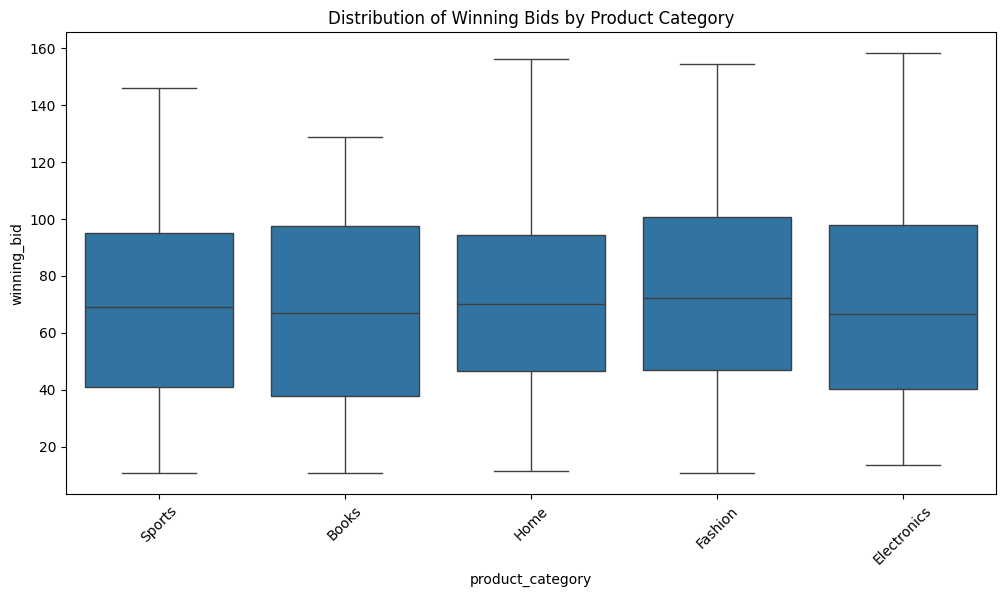

Average Winning Bid by Product Category:
  product_category  winning_bid
0            Books    68.433041
1      Electronics    71.645779
2          Fashion    72.639706
3             Home    70.030465
4           Sports    69.129351


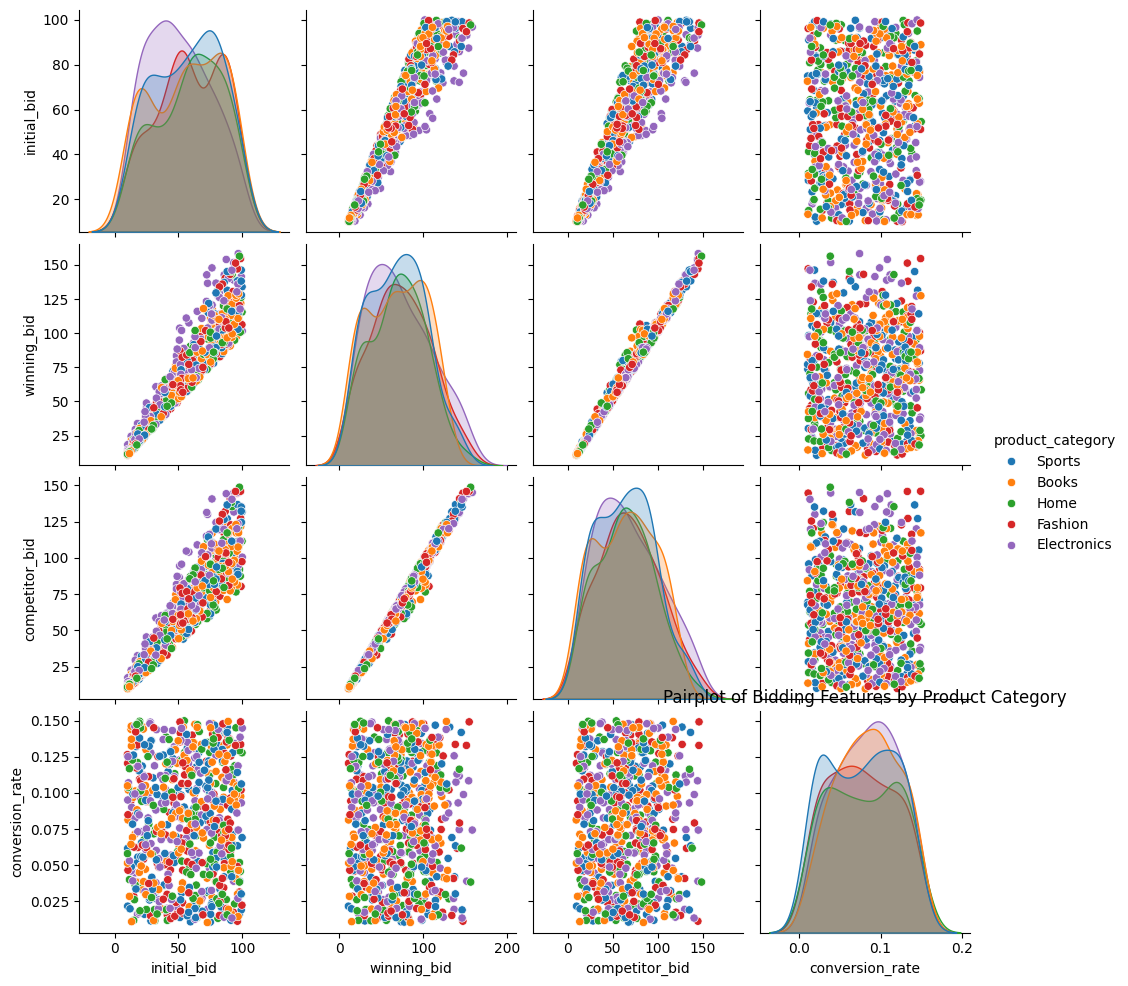

ValueError: could not convert string to float: '2024-10-06 14:33:36.972593'

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('bidding_strategy_data.csv')  # Assuming the data is in a CSV file

# Display the first few rows of the dataframe
print(df.head())

# Analyze the distribution of winning bids across different product categories
plt.figure(figsize=(12, 6))
sns.boxplot(x='product_category', y='winning_bid', data=df)
plt.title('Distribution of Winning Bids by Product Category')
plt.xticks(rotation=45)
plt.show()

# Calculate the average winning bid for each product category
average_winning_bid = df.groupby('product_category')['winning_bid'].mean().reset_index()
print("Average Winning Bid by Product Category:")
print(average_winning_bid)

# Explore the relationship between winning bids and other features
sns.pairplot(df, vars=['initial_bid', 'winning_bid', 'competitor_bid', 'conversion_rate'], hue='product_category')
plt.title('Pairplot of Bidding Features by Product Category')
plt.show()

# Correlation analysis to identify important features
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Bidding Features')
plt.show()

# Identify top factors contributing to winning bids
important_features = correlation_matrix['winning_bid'].sort_values(ascending=False)
print("Top factors contributing to winning bids:")
print(important_features)

In [137]:
class customer_analytics_agent(dspy.Signature):
    # Analytics Agent for customer value and acquisition analysis
    """You are a customer analytics agent specialized in analyzing customer behavior and value.
    Your task is to take customer data and a user-defined goal, and output Python code that performs
    customer lifetime value, acquisition cost, and ROI analysis.
    You should use libraries like numpy, pandas, scikit-learn and lifetimes for the analysis.

    Customer analytics tasks include:
    - Customer Lifetime Value (CLV/LTV) modeling
    - Customer Acquisition Cost (CAC) analysis 
    - Customer segmentation and clustering
    - Churn prediction and prevention
    - Customer journey mapping
    - ROI and retention metrics
    - Purchase behavior analysis

    Make sure your output is as intended!

    Use Plotly for all visualizations, with plotly_white theme. 




    Use display to show the output in jupyter notebook

    data is loaded as customer_df, use customer_df.copy(), make a copy don't change the original customer_df.
    DATA IS ALREADY LOADED

    

    
    """
    dataset = dspy.InputField(desc="Available datasets loaded in the system, use this df,columns. set df as copy of df")
    goal = dspy.InputField(desc="The user defined goal ")
    code = dspy.OutputField(desc="The Python code that performs the customer analytics")
    commentary = dspy.OutputField(desc="The comments about what customer analysis is being performed")

In [155]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

def generate_enhanced_cltv_dataset(n_customers=1000, start_date=datetime(2022, 1, 1), end_date=datetime(2024, 1, 1)):
    
    def generate_customer_preferences():
        """Generate random customer preferences for categories and channels"""
        categories = ['Electronics', 'Clothing', 'Home', 'Beauty', 'Food', 'Sports', 'Books', 'Toys']
        # Each customer has random preference weights for categories
        category_weights = np.random.dirichlet(np.random.uniform(0.5, 2, len(categories)))
        channel_weights = np.random.dirichlet(np.random.uniform(0.5, 2, 3))  # For online, store, mobile
        return dict(zip(categories, category_weights)), dict(zip(['Online', 'Store', 'Mobile_App'], channel_weights))

    def generate_price_variation(base_price, date, customer_segment):
        """Generate price variations based on multiple factors"""
        # Base random variation
        price = base_price * np.random.normal(1, 0.15)  # 15% standard deviation
        
        # Seasonal effects with random strength
        month = date.month
        day_of_week = date.weekday()
        
        # Holiday season (Nov-Dec) with variable impact
        if month in [11, 12]:
            price *= np.random.uniform(0.7, 1.3)  # Some items more expensive, some on sale
        
        # Summer sale (Jun-Aug) with variable discounts
        elif month in [6, 7, 8]:
            price *= np.random.uniform(0.6, 0.9)
        
        # Weekend variations
        if day_of_week >= 5:
            price *= np.random.uniform(0.9, 1.1)
        
        # Flash sales (random chance)
        if np.random.random() < 0.05:  # 5% chance of flash sale
            price *= np.random.uniform(0.5, 0.7)
        
        # Customer segment impact with random variation
        segment_multipliers = {
            'High': np.random.normal(1.1, 0.1),
            'Medium': np.random.normal(1.0, 0.1),
            'Low': np.random.normal(0.9, 0.1)
        }
        price *= segment_multipliers[customer_segment]
        
        return max(price, base_price * 0.4)  # Ensure price doesn't go too low

    def generate_customer_transactions(customer_info, product_categories):
        transactions = []
        current_date = customer_info['first_purchase_date']
        
        # Generate random customer preferences
        category_preferences, channel_preferences = generate_customer_preferences()
        
        # Random purchase frequency based on multiple factors
        base_frequency = {
            'High': np.random.normal(15, 5),
            'Medium': np.random.normal(30, 10),
            'Low': np.random.normal(45, 15)
        }[customer_info['customer_segment']]
        
        # Add customer-specific randomness to purchase frequency
        purchase_frequency = max(5, np.random.normal(base_frequency, base_frequency * 0.2))
        
        # Generate varying engagement levels over time
        engagement_trend = np.random.choice(['stable', 'increasing', 'decreasing', 'seasonal'])
        
        while current_date <= end_date:
            # Adjust purchase probability based on engagement trend
            base_purchase_prob = np.random.beta(2, 3)  # Random base probability
            
            if engagement_trend == 'increasing':
                days_since_start = (current_date - customer_info['first_purchase_date']).days
                base_purchase_prob *= min(1.5, 1 + (days_since_start / 365))
            elif engagement_trend == 'decreasing':
                days_since_start = (current_date - customer_info['first_purchase_date']).days
                base_purchase_prob *= max(0.5, 1 - (days_since_start / 365))
            elif engagement_trend == 'seasonal':
                season_factor = 1 + 0.3 * np.sin(2 * np.pi * current_date.month / 12)
                base_purchase_prob *= season_factor
            
            # Determine if purchase happens
            if np.random.random() < base_purchase_prob:
                # Random number of items per transaction with more variation
                n_items = np.random.negative_binomial(3, 0.5) + 1  # More variable number of items
                
                for _ in range(n_items):
                    # Select category based on customer preferences
                    category = np.random.choice(list(category_preferences.keys()), 
                                             p=list(category_preferences.values()))
                    
                    base_price = product_categories['base_price'][category] * \
                               np.random.normal(1, 0.2)  # 20% variation in base price
                    
                    # Generate final price with multiple sources of variation
                    final_price = generate_price_variation(base_price, current_date, 
                                                         customer_info['customer_segment'])
                    
                    # Variable quantity based on category and random factors
                    if category in ['Food', 'Beauty']:
                        quantity = np.random.negative_binomial(3, 0.5) + 1
                    else:
                        quantity = np.random.negative_binomial(2, 0.7) + 1
                    
                    # Select channel based on customer preferences
                    channel = np.random.choice(list(channel_preferences.keys()),
                                             p=list(channel_preferences.values()))
                    
                    # Random discount
                    discount = 0
                    if np.random.random() < 0.3:  # 30% chance of discount
                        discount = np.random.choice([0.1, 0.2, 0.3, 0.4, 0.5], p=[0.4, 0.3, 0.15, 0.1, 0.05])
                    
                    # Add random hour of day with category-specific patterns
                    if category in ['Food']:
                        hour = int(np.random.normal(13, 3)) % 24  # Around lunch/dinner
                    else:
                        hour = int(np.random.normal(14, 5)) % 24  # General shopping hours
                    
                    transaction_datetime = datetime.combine(current_date, 
                                                         datetime.min.time().replace(hour=hour))
                    
                    transaction = {
                        'customer_id': customer_info['customer_id'],
                        'transaction_date': transaction_datetime,
                        'product_category': category,
                        'quantity': quantity,
                        'unit_price': round(final_price * (1 - discount), 2),
                        'original_price': round(final_price, 2),
                        'discount_applied': round(discount * 100, 2),
                        'total_amount': round(final_price * quantity * (1 - discount), 2),
                        'channel': channel,
                        'is_return': np.random.random() < 0.05,  # 5% chance of return
                    }
                    transactions.append(transaction)
            
            # Variable time to next purchase attempt
            days_to_add = int(np.random.gamma(purchase_frequency, 0.5))
            current_date += timedelta(days=max(1, days_to_add))
        
        return transactions

    # Define product categories with more variation
    product_categories = {
        'category': ['Electronics', 'Clothing', 'Home', 'Beauty', 'Food', 'Sports', 'Books', 'Toys'],
        'base_price': {
            'Electronics': np.random.normal(500, 100),
            'Clothing': np.random.normal(100, 30),
            'Home': np.random.normal(200, 50),
            'Beauty': np.random.normal(50, 15),
            'Food': np.random.normal(30, 10),
            'Sports': np.random.normal(150, 40),
            'Books': np.random.normal(25, 8),
            'Toys': np.random.normal(40, 12)
        }
    }

    # Generate customer base data with more variation
    customers = []
    all_transactions = []

    # Generate different customer archetypes
    age_clusters = [
        (25, 5),  # Young
        (35, 7),  # Young Professional
        (45, 8),  # Middle Age
        (60, 10)  # Senior
    ]

    for i in range(n_customers):
        # Select age cluster and generate age
        age_mean, age_std = age_clusters[np.random.randint(0, len(age_clusters))]
        age = int(np.random.normal(age_mean, age_std))
        age = max(18, min(age, 90))  # Constrain to reasonable range
        
        # Generate income with more variation
        base_income = np.random.lognormal(11, 0.5)  # Log-normal distribution for income
        # Add age-based income adjustment
        income = int(base_income * (1 + (age - 25) * 0.01)) if age > 25 else int(base_income)
        
        # Determine customer segment based on multiple factors
        segment_score = (
            np.random.normal(income / 100000, 0.2) +  # Income factor
            np.random.normal(age / 100, 0.1) +        # Age factor
            np.random.normal(0, 0.3)                  # Random factor
        )
        
        if segment_score > 1:
            segment = 'High'
        elif segment_score > 0:
            segment = 'Medium'
        else:
            segment = 'Low'
        
        # Generate join date with more variation
        days_range = (end_date - start_date).days
        join_date = start_date + timedelta(days=np.random.beta(2, 1) * days_range)
        
        # Variable delay before first purchase
        first_purchase_delay = int(np.random.gamma(10, 2))  # More variable delay
        first_purchase_date = join_date + timedelta(days=first_purchase_delay)
        
        customer_info = {
            'customer_id': f'CUST_{i:05d}',
            'age': age,
            'gender': np.random.choice(['M', 'F', 'Other'], p=[0.48, 0.48, 0.04]),
            'income': income,
            'location': np.random.choice(
                ['Urban', 'Suburban', 'Rural', 'Remote'],
                p=[0.45, 0.35, 0.15, 0.05]
            ),
            'customer_segment': segment,
            'join_date': join_date,
            'first_purchase_date': first_purchase_date,
            'marketing_channel': np.random.choice(
                ['Social', 'Search', 'Email', 'Referral', 'Direct', 'Other'],
                p=[0.3, 0.25, 0.2, 0.15, 0.05, 0.05]
            )
        }
        
        # Generate transactions
        transactions = generate_customer_transactions(customer_info, product_categories)
        all_transactions.extend(transactions)
        customers.append(customer_info)

    # Convert to DataFrame
    df = pd.DataFrame(all_transactions)
    customers_df = pd.DataFrame(customers)

    # Merge customer information with transactions
    final_df = df.merge(customers_df, on='customer_id', how='left')

    # Calculate customer metrics
    customer_metrics = final_df.groupby('customer_id').agg({
        'transaction_date': [
            lambda x: (x.max() - x.min()).days,  # customer lifetime
            'count'  # number of transactions
        ],
        'total_amount': ['sum', 'mean', 'std'],  # transaction metrics
        'discount_applied': 'mean',
        'is_return': 'mean'
    }).reset_index()

    customer_metrics.columns = [
        'customer_id', 'customer_lifetime_days', 'total_transactions',
        'total_spent', 'avg_transaction_value', 'transaction_std',
        'avg_discount', 'return_rate'
    ]

    # Merge metrics back
    final_df = final_df.merge(customer_metrics, on='customer_id', how='left')

    # Add derived columns
    final_df['days_since_join'] = (final_df['transaction_date'] - final_df['join_date']).dt.days
    final_df['transaction_hour'] = final_df['transaction_date'].dt.hour
    final_df['transaction_day'] = final_df['transaction_date'].dt.day_name()
    final_df['transaction_month'] = final_df['transaction_date'].dt.month
    final_df['is_weekend'] = final_df['transaction_date'].dt.dayofweek.isin([5, 6])
    final_df['season'] = pd.cut(final_df['transaction_date'].dt.month, 
                               bins=[0, 3, 6, 9, 12], 
                               labels=['Winter', 'Spring', 'Summer', 'Fall'])

    # Sort by customer_id and transaction_date
    final_df = final_df.sort_values(['customer_id', 'transaction_date'])

    # Save to CSV
    final_df.to_csv('enhanced_customer_cltv_data.csv', index=False)

    # Print summary statistics
    print("\nEnhanced Dataset Summary:")
    print(f"Total number of customers: {len(final_df['customer_id'].unique())}")
    print(f"Total number of transactions: {len(final_df)}")
    print(f"Date range: {final_df['transaction_date'].min()} to {final_df['transaction_date'].max()}")
    
    print("\nMetrics by customer segment:")
    segment_metrics = final_df.groupby('customer_segment').agg({
        'total_amount': ['mean', 'std', 'sum'],
        'quantity': ['mean', 'std'],
        'discount_applied': 'mean',
        'is_return': 'mean',
        'total_transactions': 'mean'
    }).round(2)
    print(segment_metrics)
    
    return final_df

# Generate the enhanced dataset
customer_df = generate_enhanced_cltv_dataset()


Enhanced Dataset Summary:
Total number of customers: 910
Total number of transactions: 47689
Date range: 2022-02-20 03:00:00 to 2023-12-31 23:00:00

Metrics by customer segment:
                 total_amount                      quantity        \
                         mean     std          sum     mean   std   
customer_segment                                                    
High                   299.28  417.21  10490113.82     2.38  1.82   
Low                    305.73  391.47     99360.93     2.41  1.70   
Medium                 274.69  378.80   3382197.40     2.36  1.82   

                 discount_applied is_return total_transactions  
                             mean      mean               mean  
customer_segment                                                
High                         6.30      0.05             133.50  
Low                          6.03      0.05              41.12  
Medium                       6.30      0.05              71.73  


In [156]:
# df
customer_df.head()

,customer_id,transaction_date,product_category,quantity,unit_price,original_price,discount_applied,total_amount,channel,is_return,...,avg_transaction_value,transaction_std,avg_discount,return_rate,days_since_join,transaction_hour,transaction_day,transaction_month,is_weekend,season
1,CUST_00000,2023-10-16 06:00:00,Sports,2,194.19,194.19,0.0,388.38,Store,False,...,196.86225,141.151435,6.0,0.05,31,6,Monday,10,False,Fall
3,CUST_00000,2023-10-16 08:00:00,Beauty,6,109.18,109.18,0.0,655.10,Online,False,...,196.86225,141.151435,6.0,0.05,31,8,Monday,10,False,Fall
4,CUST_00000,2023-10-16 12:00:00,Clothing,1,87.08,87.08,0.0,87.08,Store,False,...,196.86225,141.151435,6.0,0.05,31,12,Monday,10,False,Fall
2,CUST_00000,2023-10-16 14:00:00,Clothing,1,103.71,103.71,0.0,103.71,Store,False,...,196.86225,141.151435,6.0,0.05,31,14,Monday,10,False,Fall
5,CUST_00000,2023-10-16 14:00:00,Sports,2,112.03,112.03,0.0,224.05,Mobile_App,False,...,196.86225,141.151435,6.0,0.05,31,14,Monday,10,False,Fall


In [157]:
query = "Build a statistical model to predict customer lifetime value, use stats models linear regression"

customer_dataset = make_data(customer_df, "Customer Lifetime Value Data, Transactional data")

customer_agent = dspy.ChainOfThought(customer_analytics_agent)

response = customer_agent(dataset=str(customer_dataset), goal=query)

print(response)



Prediction(
    rationale="produce the commentary. We need to build a statistical model to predict Customer Lifetime Value (CLV) using the available customer data. The dataset contains various features such as transaction details, customer demographics, and purchase behavior, which can be used to model CLV. We will use a linear regression model from the statsmodels library to predict CLV. The steps involved include:\n\n1. **Data Preparation**: We will first prepare the data by selecting relevant features that are likely to influence CLV. This includes features like total transactions, total spent, average transaction value, and customer lifetime days.\n\n2. **Feature Selection**: We will select features that are most relevant for predicting CLV. This involves understanding the relationship between these features and the target variable (CLV).\n\n3. **Model Building**: We will use the statsmodels library to build a linear regression model. This involves fitting the model to the data and

In [158]:
print(response.code.split('```')[1].replace('#','####').replace('python',''))
exec(response.code.split('```')[1].replace('#','####').replace('python',''))


import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.express as px
from IPython.display import display

#### Make a copy of the original dataframe
df = customer_df.copy()

#### Data Preparation: Selecting relevant features
features = ['total_transactions', 'total_spent', 'avg_transaction_value', 'customer_lifetime_days']
X = df[features]
y = df['total_spent']  #### Assuming total_spent is a proxy for CLV

#### Adding a constant to the model (intercept)
X = sm.add_constant(X)

#### Building the linear regression model
model = sm.OLS(y, X).fit()

#### Model summary
model_summary = model.summary()

#### Predictions
df['predicted_clv'] = model.predict(X)

#### Visualization: Predicted vs Actual CLV
fig = px.scatter(df, x='total_spent', y='predicted_clv', 
                 labels={'total_spent': 'Actual CLV', 'predicted_clv': 'Predicted CLV'},
                 title='Predicted vs Actual Customer Lifetime Value',
                 template='plotly_white')
fig.add

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_spent   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.737e+33
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:28:04   Log-Likelihood:             1.0513e+06
No. Observations:               47689   AIC:                        -2.103e+06
Df Residuals:                   47684   BIC:                        -2.102e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   9.095e-12   1.35e-12      6.755      0.000    6.46e-12    1.17e-11
total_transactions      3.411e-13   9.81e-15     34.777      0.000    3.22e-13     3.6e-13
total_spent                1.0000   2.88e-17   3.47e+16      0.000       1.000       1.000
avg_transaction_value  -4.263e-14   4.03e-15    -10.590      0.000   -5.05e-14   -3.47e-14
customer_lifetime_days  4.441e-14   2.26e-15     19.646      0.000       4e-14    4.88e-14
==============================================================================
Omnibus:                    14553.231   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43268.217
Skew:                          -1.601   Prob(JB):                         0.00
Kurtosis:                       6.394   Cond. No.                     2.30e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [108]:
# !pip install lifetimes


In [162]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.express as px
from IPython.display import display

#### Make a copy of the original dataframe
df = customer_df.copy().sample(n=500)

#### Data Preparation: Selecting relevant features
features = ['total_transactions', 'total_spent', 'avg_transaction_value', 'customer_lifetime_days']
X = df[features]
y = df['total_spent']  #### Assuming total_spent is a proxy for CLV

#### Adding a constant to the model (intercept)
X = sm.add_constant(X)

#### Building the linear regression model
model = sm.OLS(y, X).fit()

#### Model summary
model_summary = model.summary()

#### Predictions
df['predicted_clv'] = model.predict(X)

df['total_spent'] = df['total_spent'] + np.random.normal(0, df['total_spent'].std() * 0.3, len(df)) + \
                    np.random.exponential(df['total_spent'].mean() * 0.1, len(df)) - \
                    np.random.uniform(0, df['total_spent'].max() * 0.05, len(df))

#### Visualization: Predicted vs Actual CLV
fig = px.scatter(df, x='total_spent', y='predicted_clv', 
                 labels={'total_spent': 'Actual CLV', 'predicted_clv': 'Predicted CLV'},
                 title='Predicted vs Actual Customer Lifetime Value',
                 template='plotly_white')
fig.add_shape(type='line', x0=0, y0=0, x1=df['total_spent'].max(), y1=df['total_spent'].max(),
              line=dict(color='Red',), xref='x', yref='y')

#### Display the model summary and plot
display(model_summary)
fig.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_spent   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.777e+32
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:31:20   Log-Likelihood:                 11659.
No. Observations:                 500   AIC:                        -2.331e+04
Df Residuals:                     495   BIC:                        -2.329e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -4.093e-12    3.7e-12     -1.106      0.269   -1.14e-11    3.18e-12
total_transactions     -5.684e-14   2.75e-14     -2.067      0.039   -1.11e-13   -2.82e-15
total_spent                1.0000   8.48e-17   1.18e+16      0.000       1.000       1.000
avg_transaction_value   5.862e-14   1.07e-14      5.496      0.000    3.77e-14    7.96e-14
customer_lifetime_days  5.151e-14   6.15e-15      8.371      0.000    3.94e-14    6.36e-14
==============================================================================
Omnibus:                      154.183   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              434.383
Skew:                           1.494   Prob(JB):                     4.73e-95
Kurtosis:                       6.453   Cond. No.                     2.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""